# Predicting Nuclear Masses with PyTorch


## Introduction

### Semi-Empirical Mass Formula (Weizsäcker)

The semi-empirical mass formula (SEMF), also called the liquid-drop model, approximates the binding energy B(Z,N) of a nucleus as a sum of macroscopic terms:

$$B(A,Z) = a_V A - a_S A^{2/3} - a_C \frac{Z(Z-1)}{A^{1/3}} - a_A \frac{(N-Z)^2}{A} + \delta(A,Z)$$

where:

- $A=N+Z$ is the mass number.
- $a_V$ (volume term) accounts for binding from short-range nuclear forces proportional to A.
- $a_S$ (surface term) corrects for nucleons on the surface having fewer neighbours ($\sim A^{2/3}$).
- $a_C$ (Coulomb term) is the electrostatic repulsion between protons ($\sim Z(Z-1)/A^{1/3}$).
- $a_A$ (asymmetry term) penalizes neutron–proton imbalance; related to Pauli exclusion.
- $\delta(A,Z)$ (pairing term) adds/subtracts small energy depending on even/odd proton and neutron numbers (typically $±a_P A^{-1/2}$ or 0).

In practice the coefficients $a_V,a_S,a_C,a_A,a_P$ are fit to experimental masses (e.g., AME datasets), giving a simple analytic predictor for nuclear masses or mass excess.

**Pros:**

- Intuitive macroscopic picture; few parameters and closed-form expression.
- Captures global trends across the nuclear chart (bulk binding, Coulomb effects, asymmetry, pairing).
- Useful as baseline, for generating features, or for extrapolation where data are sparse.

**Cons / Limitations:**

- Misses microscopic shell effects and detailed structure (shell closures, deformation energy).
- Pairing and shell corrections are empirical or require separate microscopic models.
- Accuracy limited (typically several MeV) compared with high-precision mass tables (keV).
- Parameter fits can be biased by dataset choice; uncertain when extrapolating far from known nuclides.

**References and further reading:**

- [C. F. von Weizsäcker, "Zur Theorie der Kernmassen", Zeitschrift für Physik 96, 431 (1935)](https://link.springer.com/article/10.1007/BF01337700).
- [A. H. Wapstra, G. Audi, and C. Thibault, "The AME2003 atomic mass evalution"](https://www.sciencedirect.com/science/article/abs/pii/S0375947403018098).
- [M. Wang et al., "The AME2020 atomic mass evaluation"](https://iopscience.iop.org/article/10.1088/1674-1137/abddaf).
- K. S. Krane, "Introductory Nuclear Physics", Wiley.

Below we will use AME2020 data to train a neural network (NN). The SEMF can be incorporated in the network to create physics-informed features. SEMF will be also used to compare the NN model.


### AME2020

This notebook uses the AME2020 `mass_1.mas20.txt` file as the database for nuclide masses.

Data sources:

- https://amdc.in2p3.fr/masstables/Ame2020/mass_1.mas20.txt
- https://www-nds.iaea.org/amdc/

References:

- https://iopscience.iop.org/article/10.1088/1674-1137/abddb0
- https://doi.org/10.1088/1674-1137/abddaf


## Preparing the Notebook

This section sets up the notebook environment, imports necessary libraries, and defines utility functions for data loading, preprocessing, and model evaluation. Here we ensure that all dependencies are in place for the subsequent analysis and modeling tasks. The data loading functions will read the AME2020 mass table and prepare it for training the neural network model.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import logging
from tqdm.notebook import tqdm

from data import (
    AME2020Parser,
)  # Importing the AME2020Parser from data.py found in the same directory

logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(message)s", level=logging.INFO
)
logger = logging.getLogger(__name__)

In [2]:
# Download AME2020 mass_1.mas20.txt using a helper parser class

url = "https://www-nds.iaea.org/amdc/ame2020/mass_1.mas20.txt"

parser = AME2020Parser()
df_full = parser.load(url)  # full dataframe for reference

df_full

2025-12-04 14:39:14,589 - INFO - Downloading and parsing AME2020 mass table from https://www-nds.iaea.org/amdc/ame2020/mass_1.mas20.txt


,N-Z,N,Z,A,ELEMENT_SYMBOL,O,MASS EXCESS (keV),SIGMA MASS EXCESS (keV),BINDING ENERGY/A (keV),SIGMA BINDING ENERGY/A (keV),BETA DECAY TYPE,BETA-DECAY ENERGY (keV),SIGMA BETA-DECAY ENERGY (keV),ATOMIC MASS (micro-u),SIGMA ATOMIC MASS (micro-u),MASS EXCESS ESTIMATED,BINDING ENERGY ESTIMATED,BETA DECAY ENERGY ESTIMATED,ATOMIC MASS ESTIMATED
0,1,1,0,1,n,None,8071.318060,0.000440,0.00000,0.00000,B-,782.34700,0.00040,1.008665e+06,0.000470,False,False,False,False
1,-1,0,1,1,H,None,7288.971064,0.000013,0.00000,0.00000,B-,NaN,NaN,1.007825e+06,0.000014,False,False,False,False
2,0,1,1,2,H,None,13135.722895,0.000015,1112.28310,0.00020,B-,NaN,NaN,2.014102e+06,0.000015,False,False,False,False
3,1,2,1,3,H,None,14949.810900,0.000080,2827.26540,0.00030,B-,18.59202,0.00006,3.016049e+06,0.000080,False,False,False,False
4,-1,1,2,3,He,None,14931.218880,0.000060,2572.68044,0.00015,B-,-13736.00000,2000.00000,3.016029e+06,0.000060,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3553,59,176,117,293,Ts,-a,194428.000000,778.000000,7095.00000,3.00000,B-,-4374.00000,1053.00000,2.932087e+08,835.000000,True,True,True,True
3554,57,175,118,293,Og,-a,198802.000000,709.000000,7078.00000,2.00000,B-,NaN,NaN,2.932134e+08,761.000000,True,True,False,True
3555,60,177,117,294,Ts,-a,196397.000000,593.000000,7092.00000,2.00000,B-,-2923.00000,811.00000,2.942108e+08,637.000000,True,True,True,True
3556,58,176,118,294,Og,-a,199320.000000,553.000000,7079.00000,2.00000,B-,NaN,NaN,2.942140e+08,594.000000,True,True,False,True


## SEMF vs. AME2020 Masses

This section compares the SEMF predictions to the AME2020 experimental masses to illustrate the limitations of the SEMF model.

In [3]:
# SEMF and Utility Functions


def semi_empirical_mass_formula(
    Z: np.ndarray, A: np.ndarray, a_v=15.75, a_s=17.8, a_c=0.711, a_a=23.7, a_p=11.18
):
    """Semi-empirical mass formula (Weizsäcker formula) to estimate binding energy B(Z, A)."""

    # Volume term
    B_v = a_v * A
    # Surface term
    B_s = a_s * np.pow(A, 2.0 / 3.0)
    # Coulomb term
    B_c = a_c * Z * (Z - 1) / np.pow(A, 1.0 / 3.0)
    # Asymmetry term
    B_a = a_a * np.pow((A - 2 * Z), 2.0) / A
    # Pairing term
    delta = 0
    if A % 2 == 0:
        if Z % 2 == 0:
            delta = a_p / np.pow(A, 1.0 / 2.0)
        else:
            delta = -a_p / np.pow(A, 1.0 / 2.0)

    B = B_v - B_s - B_c - B_a + delta
    return B


def nuclear_mass(Z: int | np.ndarray, A: int | np.ndarray) -> np.ndarray:
    """Calculate nuclear mass M(Z, A) in atomic mass units (u)."""
    m_p = 1.007276466621  # mass of proton in u
    m_n = 1.00866491588  # mass of neutron in u
    B = np.array(
        [semi_empirical_mass_formula(z, a) for z, a in zip(Z, A)]
    )  # binding energy in MeV
    M = Z * m_p + (A - Z) * m_n - B / 931.49410242  # Convert MeV to u
    return M


# Utility functions for analysis


def relative_error(y_true, y_pred):
    return (y_true - y_pred) / y_true


def absolute_relative_error(y_true, y_pred):
    return np.abs((y_true - y_pred) / y_true)


def mean_relative_error(y_true, y_pred):
    # handle division by zero or nan by ignoring those cases
    y_valid = y_true != 0
    y_true = y_true[y_valid]
    y_pred = y_pred[y_valid]

    return np.mean(absolute_relative_error(y_true, y_pred))

SEMF performance against AME2020 data
MRE = 3.147e-04
MAE = 38108.664 micro-u
RMSE = 42923.754 micro-u


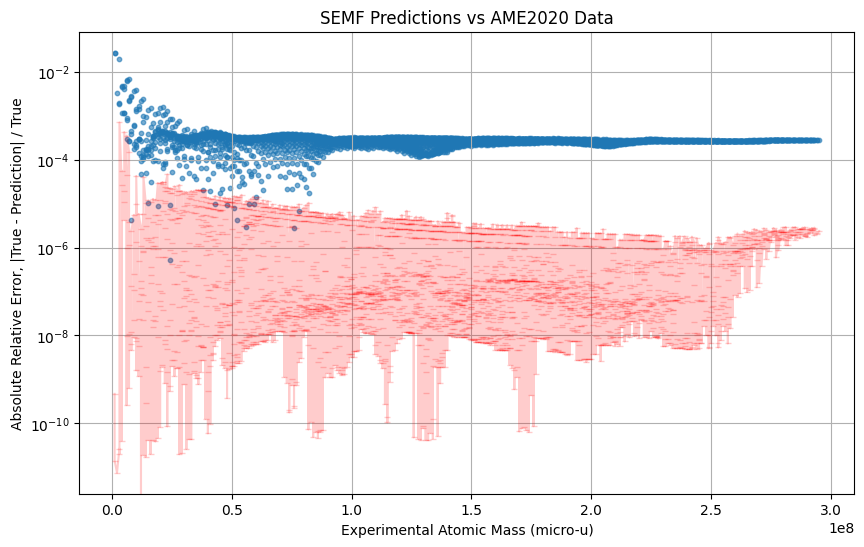

In [4]:
# Plot SEMF predictions vs experimental data
y_true = df_full["ATOMIC MASS (micro-u)"].to_numpy()
y_semf = 1e6 * nuclear_mass(df_full["Z"].values, df_full["A"].values)  # in micro-u


mre = mean_relative_error(y_true, y_semf)
mae = mean_absolute_error(y_true, y_semf)
rmse = np.sqrt(mean_squared_error(y_true, y_semf))


dy = df_full["SIGMA ATOMIC MASS (micro-u)"].to_numpy()
relative_dy = dy / y_true

print("SEMF performance against AME2020 data")
print(f"MRE = {mre:.3e}")
print(f"MAE = {mae:.3f} micro-u")
print(f"RMSE = {rmse:.3f} micro-u")


plt.figure(figsize=(10, 6))
plt.scatter(y_true, absolute_relative_error(y_true, y_semf), s=10, alpha=0.6)
plt.plot(
    y_true,
    relative_dy,
    marker="_",
    color="red",
    alpha=0.2,
    markersize=4,
    label="AME2020 Uncertainty",
)
plt.xlabel("Experimental Atomic Mass (micro-u)")
plt.ylabel("Absolute Relative Error, |True - Prediction| / True")
plt.title("SEMF Predictions vs AME2020 Data")
plt.yscale("log")
plt.grid(True)
plt.show()

## Neural Network

Neural networks can capture complex, non-linear relationships in data. Here we define a feedforward neural network architecture using PyTorch to predict nuclear masses based on proton number (Z) and neutron number (N). The model will be trained on the AME2020 dataset, and we will evaluate its performance against the SEMF predictions.

There is a journal article that discusses using neural networks for nuclear mass predictions:

https://journals.aps.org/prc/pdf/10.1103/PhysRevC.111.034329

This article can provide insights into model architecture, training strategies, and performance benchmarks for comparison. The neural network in this notebook is inspired by the approaches discussed in the article but is implemented more simply for educational purposes.

### Feature Engineering

Feature engineering can significantly impact model performance. Here we create additional features based on physical insights. Nuclear properties often depend on combinations of Z and A, so we add features like N (neutron number), Z/A ratio, and pairing indicators. Also the magic numbers are included as binary features to help the model learn shell effects.

In [5]:
# Prepare features and target
# We'll predict mass in micro-u. Use Z,N,A & simple engineered features.


def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """Add engineered features to the dataframe."""

    proton_magic_numbers = [2, 8, 20, 28, 50, 82, 126]
    neutron_magic_numbers = [2, 8, 20, 28, 50, 82, 126, 184]

    df["Z^2"] = (df["Z"] ** 2).astype(float)
    df["A^(2/3)"] = (df["A"] ** (2.0 / 3.0)).astype(float)
    df["A^(-1/3)"] = (df["A"] ** (-1.0 / 3.0)).astype(float)
    df["A^(-1/2)"] = (df["A"] ** (-1.0 / 2.0)).astype(float)
    df["(N-Z)^2"] = ((df["N"] - df["Z"]) ** 2).astype(float)
    df["ZperA"] = (df["Z"] / df["A"]).astype(float)
    df["Z_parity"] = (df["Z"] % 2).astype(float)
    df["N_parity"] = (df["N"] % 2).astype(float)
    df["is_magic"] = df.apply(
        lambda row: 1.0
        if row["Z"] in proton_magic_numbers or row["N"] in neutron_magic_numbers
        else 0.0,
        axis=1,
    )
    return df


df_full = feature_engineering(df_full)

df = df_full.copy()

In [6]:
# Select only nuclides with experimental mass values for training, validation, and testing

df = df[~df["MASS EXCESS ESTIMATED"]]

# Define input and target features
# NOTE: The first four input features need to be in this order for the model

# INPUT
x_features = [
    "N-Z",
    "N",
    "Z",
    "A",
    "ZperA",
    "Z_parity",
    "N_parity",
    "is_magic",
    "Z^2",
    "A^(2/3)",
    "A^(-1/3)",
    "A^(-1/2)",
    "(N-Z)^2",
]
X = df[x_features].values.astype(np.float32)

# OUTPUT (or TARGET)
TARGET_FEATURE = "ATOMIC MASS (micro-u)"
y = df[TARGET_FEATURE].values.astype(np.float32).reshape(-1, 1)

In [7]:
# Split data into training, validation, and test sets (50% / 25% / 25%)

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25 / 0.75, random_state=42
)

print(f"The total size of the database is {df_full.shape[0]}")
print(
    f"After excluding the nuclides that only have estimated values the size in {df.shape[0]}"
)
print(
    "This dataset is diviced for training, validation and testing the neural network as follows:"
)
print(
    f"trainining: {X_train.shape[0]}, validation: {X_val.shape[0]}, testing: {X_test.shape[0]}"
)

# Scale input features
scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

The total size of the database is 3558
After excluding the nuclides that only have estimated values the size in 2550
This dataset is diviced for training, validation and testing the neural network as follows:
trainining: 1274, validation: 638, testing: 638


In [8]:
# Create PyTorch Dataset and DataLoader (return SEMF separately)


class MassDataset(Dataset):
    def __init__(
        self, X: np.ndarray | float, semf: np.ndarray | float, y: np.ndarray | float
    ):
        # X: scaled input features (N, n_feat)
        # semf: SEMF baseline in the same units as y (N,)
        # y: target values (N, 1)
        self.X = torch.from_numpy(X).float()
        self.semf = torch.from_numpy(semf.astype(np.float32)).float().reshape(-1, 1)
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # returns: (features, semf_scalar, target)
        return self.X[idx], self.semf[idx], self.y[idx]


# Precompute SEMF for train/val/test (keep units consistent with y, here micro-u)
semf_train = 1e6 * nuclear_mass(Z=X_train[:, 2], A=X_train[:, 3])
semf_val = 1e6 * nuclear_mass(Z=X_val[:, 2], A=X_val[:, 3])
semf_test = 1e6 * nuclear_mass(Z=X_test[:, 2], A=X_test[:, 3])

batch_size = 64
train_ds = MassDataset(X_train_s, semf_train, y_train)
val_ds = MassDataset(X_val_s, semf_val, y_val)
test_ds = MassDataset(X_test_s, semf_test, y_test)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print("Batches per epoch:", len(train_loader))

Batches per epoch: 20


### Defining the Neural Network Model

In [9]:
# Define model, loss, optimizer (residual / SEMF passed separately)

in_dim = X_train_s.shape[1]


class MLP(nn.Module):
    def __init__(self, in_dim: int, hidden_depth: int = 2, width: int = 128):
        super().__init__()

        # Using GELU activation function
        activation = nn.GELU()

        # Ensure at least one hidden layer
        hidden_depth = max(1, int(hidden_depth))

        # input layer
        layers = [nn.Linear(in_dim, width), activation]

        # add additional hidden layers of size `width`
        for _ in range(hidden_depth - 1):
            layers.extend([nn.Linear(width, width), activation])

        # final output layer (predicts delta)
        layers.append(nn.Linear(width, 1))

        # create the sequential model
        self.net = nn.Sequential(*layers)

    def forward(self, x, semf):
        # x: normalized features (batch, n_feat)
        # semf: baseline (batch, 1) in same units as target
        delta = self.net(x)
        return semf + delta


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model with 3 hidden layers and 64 neurons each
hidden_depth = 3
width = 64

model = MLP(in_dim, hidden_depth=hidden_depth, width=width).to(device)

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("Device:", device)
print(model)

# Number of trained parameters
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {n_params}")


Device: cpu
MLP(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)
Number of trainable parameters: 9281


### Training the Model

In [10]:
# Training loop with validation (uses semf returned by dataset)
epochs = 5000
best_val = float("inf")
history = {"train_loss": [], "val_loss": []}
best_model_state = None
best_model_epoch = None
stop_training = False

for ep in tqdm(range(1, epochs + 1)):
    model.train()

    train_losses = []

    for xb, semf_b, yb in train_loader:
        xb = xb.to(device)
        semf_b = semf_b.to(device)
        yb = yb.to(device)

        pred = model(xb, semf_b)

        # data loss
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = float(np.mean(train_losses))

    if train_loss < best_val:
        best_model_epoch = ep
        best_val = train_loss
        best_model_state = model.state_dict()

    model.eval()

    # Validate the model to monitor overfitting
    val_losses = []
    with torch.no_grad():
        for xb, semf_b, yb in val_loader:
            xb = xb.to(device)
            semf_b = semf_b.to(device)
            yb = yb.to(device)
            pred = model(xb, semf_b)
            val_losses.append(loss_fn(pred, yb).item())

    val_loss = float(np.mean(val_losses))

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    if ep - best_model_epoch >= 1000:
        print(f"No improvement in 1000 epochs, stopping training at epoch {ep}.")
        stop_training = True

    if ep % 500 == 0 or ep == 1 or stop_training:
        print(
            f"Epoch {ep:03d}: train_loss={train_loss:.3e}, val_loss={val_loss:.3e}, best_val={best_val:.3e}, {best_model_epoch=}"
        )

    if stop_training:
        break
# Load the best model state

print(
    f"Best model found at epoch {best_model_epoch} with validation loss {best_val:.3e}"
)
model.load_state_dict(best_model_state)

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 001: train_loss=1.658e+09, val_loss=1.639e+09, best_val=1.658e+09, best_model_epoch=1
Epoch 500: train_loss=3.350e+06, val_loss=4.198e+06, best_val=3.350e+06, best_model_epoch=500
Epoch 1000: train_loss=2.439e+06, val_loss=3.585e+06, best_val=2.439e+06, best_model_epoch=1000
Epoch 1500: train_loss=2.243e+06, val_loss=2.995e+06, best_val=2.140e+06, best_model_epoch=1461
Epoch 2000: train_loss=2.125e+06, val_loss=3.297e+06, best_val=1.962e+06, best_model_epoch=1991
Epoch 2500: train_loss=1.914e+06, val_loss=2.728e+06, best_val=1.837e+06, best_model_epoch=2476
Epoch 3000: train_loss=1.770e+06, val_loss=2.811e+06, best_val=1.721e+06, best_model_epoch=2954
Epoch 3500: train_loss=1.661e+06, val_loss=2.488e+06, best_val=1.619e+06, best_model_epoch=3422
Epoch 4000: train_loss=1.540e+06, val_loss=2.416e+06, best_val=1.526e+06, best_model_epoch=3911
Epoch 4500: train_loss=1.492e+06, val_loss=2.606e+06, best_val=1.428e+06, best_model_epoch=4454
Epoch 5000: train_loss=1.354e+06, val_loss=2.2

<All keys matched successfully>

#### Show training progress

This cell shows the training progress by plotting the training and validation loss over epochs.

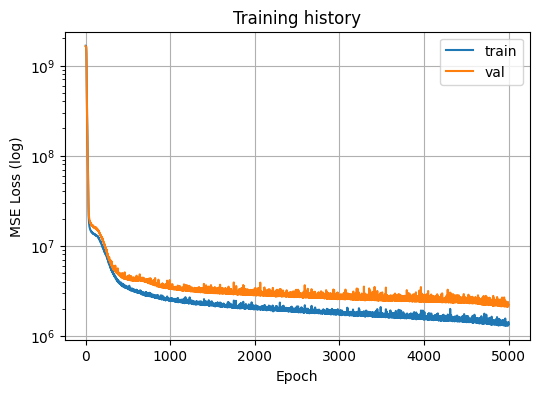

In [11]:
# Plot losses
plt.figure(figsize=(6, 4))
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss (log)")
plt.legend()
plt.title("Training history")
plt.grid(True)
plt.show()

#### Compute test set performance

This cell computes the performance of the trained model on the test set and compares it to the SEMF baseline. 

> Note: The data in the test set has not been used during training or validation, so it provides an unbiased estimate of the model's generalization performance.

Number of test samples: 638
Model performance on test set
MRE = 1.679e-05
MAE = 1045.948 micro-u
RMSE = 1474.366 micro-u


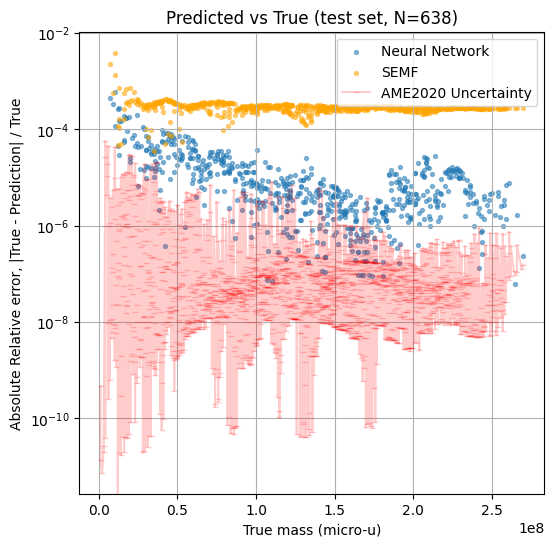

In [12]:
# Evaluate the model on test set

model.eval()

X_test_t = torch.from_numpy(X_test_s).float().to(device)
# create tensor for the SEMF baseline for the test set
semf_test_t = (
    torch.from_numpy(semf_test.astype(np.float32)).float().reshape(-1, 1).to(device)
)

with torch.no_grad():
    preds = model(X_test_t, semf_test_t).cpu().numpy().reshape(-1)
y_true = y_test.reshape(-1)

# Compute mean relative errors

print(f"Number of test samples: {len(y_true)}")

mre = mean_relative_error(y_true, preds)
mae = mean_absolute_error(y_true, preds)
rmse = np.sqrt(mean_squared_error(y_true, preds))

print("Model performance on test set")
print(f"MRE = {mre:.3e}")
print(f"MAE = {mae:.3f} micro-u")
print(f"RMSE = {rmse:.3f} micro-u")


y_semf = 1e6 * nuclear_mass(Z=X_test[:, 2], A=X_test[:, 3])

# AME2020 uncertainty
dy = df["SIGMA ATOMIC MASS (micro-u)"].to_numpy()
y_all = df[TARGET_FEATURE].to_numpy()
relative_dy = dy / y_all

# Scatter plot predicted vs true (relative error)
plt.figure(figsize=(6, 6))
plt.scatter(
    y_true,
    absolute_relative_error(y_true, preds),
    s=8,
    alpha=0.5,
    label="Neural Network",
)
plt.scatter(
    y_true,
    absolute_relative_error(y_true, y_semf),
    s=8,
    alpha=0.5,
    color="orange",
    label="SEMF",
)
plt.plot(
    y_all,
    relative_dy,
    marker="_",
    color="red",
    alpha=0.2,
    markersize=4,
    label="AME2020 Uncertainty",
)

plt.xlabel("True mass (micro-u)")
plt.ylabel("Absolute Relative error, |True - Prediction| / True")
plt.title(f"Predicted vs True (test set, N={len(y_true)})")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

### Testing the Model with the extrapolated mass values in AME2020 database

This section tests the trained model on nuclides whose masses are extrapolated in the AME2020 database. These nuclides are typically far from stability and were not included in the training set. The goal is to evaluate how well the model generalizes to these challenging cases compared to the SEMF baseline.

Nuclides with Estimated Mass Values in AME2020:
Number of samples: 1008
MRE = 2.681e-05
MAE = 1444.179 micro-u
RMSE = 2088.184 micro-u


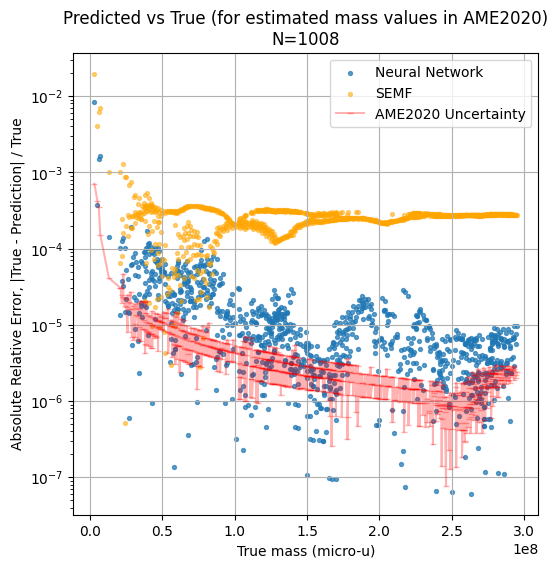

In [13]:
# Compare Mass Prediction for those nuclides that have estimated mass values in AME2020

df = df_full.copy()

# select only nuclides with estimated mass excess
df = df[df["MASS EXCESS ESTIMATED"]]

X = df[x_features].values.astype(np.float32)
y = df[TARGET_FEATURE].values.astype(np.float32).reshape(-1, 1)

# generate scaled input features for the model
X_s = scaler.transform(X)
semf_df = 1e6 * nuclear_mass(Z=df["Z"].values, A=df["A"].values)
X_t = torch.from_numpy(X_s).float().to(device)
semf_t = torch.from_numpy(semf_df.astype(np.float32)).float().reshape(-1, 1).to(device)


with torch.no_grad():
    preds = model(X_t, semf_t).cpu().numpy().reshape(-1)
y_true = y.reshape(-1)

mre = mean_relative_error(y_true, preds)
mae = mean_absolute_error(y_true, preds)
rmse = np.sqrt(mean_squared_error(y_true, preds))

print("Nuclides with Estimated Mass Values in AME2020:")
print(f"Number of samples: {len(y_true)}")
print(f"MRE = {mre:.3e}")
print(f"MAE = {mae:.3f} micro-u")
print(f"RMSE = {rmse:.3f} micro-u")


# plot the uncertainty of estimated mass values given in the AME2020 database
dy = df["SIGMA ATOMIC MASS (micro-u)"].to_numpy()
relative_dy = dy / y_true

# Scatter plot predicted vs true
plt.figure(figsize=(6, 6))
plt.scatter(
    y_true,
    absolute_relative_error(y_true, preds),
    s=8,
    alpha=0.7,
    label="Neural Network",
)
plt.scatter(
    y_true,
    absolute_relative_error(y_true, semf_df),
    s=8,
    alpha=0.5,
    color="orange",
    label="SEMF",
)
plt.plot(
    y_true,
    relative_dy,
    marker="_",
    color="red",
    alpha=0.3,
    markersize=4,
    label="AME2020 Uncertainty",
)

plt.xlabel("True mass (micro-u)")
plt.ylabel("Absolute Relative Error, |True - Prediction| / True")
plt.title(f"Predicted vs True (for estimated mass values in AME2020)\nN={len(y_true)}")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

### How to read the graphs

The graphs in this notebook plot the absolute relative error of predicted nuclear masses compared to the AME2020 experimental values. The y-axis shows the absolute relative error, calculated as:

$$\text{Absolute Relative Error} = \left| \frac{M_{\text{predicted}} - M_{\text{AME2020}}}{M_{\text{AME2020}}} \right|$$

The AME2020 Uncertainty line indicates the typical uncertainty in the experimental mass measurements from the AME2020 database. This provides a benchmark for evaluating model performance. If the model's error is below this line, it suggests that the predictions are within the experimental uncertainty, indicating good agreement with measured values.
